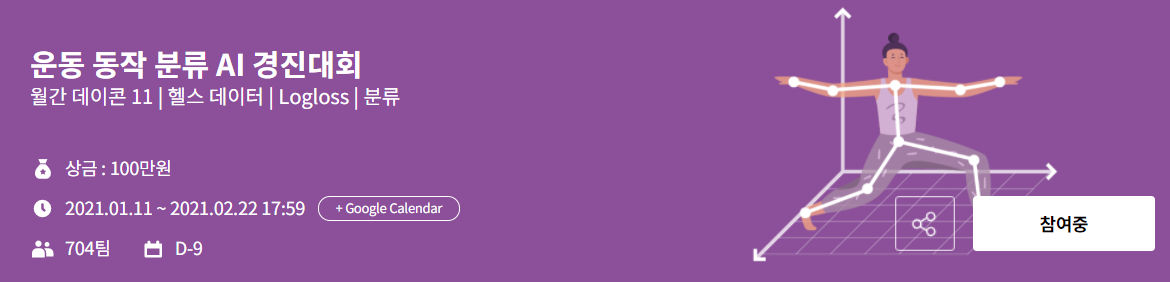

### [DACON 운동 동작 분류 AI 경진대회]





#### [주제 및 배경]



- 운동 동작 인식 알고리즘 개발
- 스마트 헬스케어 산업에 적용 가능한 데이터 분석 방법 




#### [대회 설명]



- 3축 가속도계(accelerometer)와 3축 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터에 머신러닝 알고리즘을 적용해 운동 동작 인식 알고리즘 개발

#### [데이터]





- 3축 가속도계(accelerometer)와 3축 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터





1. train_features.csv (1875000, 8)  



    - id 별 600 time 간 동작 데이터
    - id 3125개 x 600 time =1875000 데이터




2. train_labels.csv (3125, 3)



    - id 별 동작과 동작 label(61개)


3. test_features.csv (469200, 8)



    - id 별 600 time간 동작 데이터
    - id 782개 x 600 time =469200 데이터




4. sample_submission.csv (782, 62)



    - id별 동작을 예측해 작성하는 csv

### 평가



#### 심사 기준: LogLoss
1. 1차 평가(Public Score): 테스트 데이터 중 랜덤 샘플 된 50%로 채점, 대회 기간 중 공개
2. 2차 평가(Private Score): 나머지 50 % 테스트 데이터로 채점, 대회 종료 직후 공개



In [ ]:
import tensorflow as tf
import torch
import torchvision
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot
%matplotlib inline

In [ ]:
trainroot = '/content/drive/MyDrive/DACON_MotionCV/train_features.csv'
trainYroot = '/content/drive/MyDrive/DACON_MotionCV/train_labels.csv'
testroot = '/content/drive/MyDrive/DACON_MotionCV/test_features.csv'

train_features = pd.read_csv(trainroot)
train_labels = pd.read_csv(trainYroot)
test_features = pd.read_csv(testroot)

In [ ]:
train_features.head(3)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629


- 데이터의 내용물을 간단히 보자면 acc_x, acc_y, acc_z의 경우에는 3축의 가속도계가 측정한 데이터이고
- gy_x, gy_y, gy_z의 경우에는 3축의 자이로스코프가 측정한 데이터이다.
- 따라서 각각을 어떤 데이터로 입력을 하고 확인을 하는 것이 좋을지 판단을 잘 할 수 있어야 한다.
**데이터의 상태를 자세히 본다면 각각의 id별로 시간 순서대로 6 X 100, 즉600개의 데이터가 존재함을 알 수 있다.*

  1. 시계열 데이터로 본다면 이전의 데이터로부터 학습을 해야 하고, 만약에 우리가 RNN의 encoder - decoder을 이용하고 여기에 Attention을 적용하게 된다면 문제가 풀릴 수도 있을 것이다.
  2. 아니면 그냥 simple is best를 이용해서 그냥 sklearn의 machine learning을 이용해서 분류 문제로 풀 수도 있겠지만 train set에 대한 overfitting이 발생할 위험이 클 것으로 보인다.
  3. Transformer Model이나 Attention+LSTM 사용
    - 각각의 column데이터를 따로따로 간주하기 보다는... 음..아니면 차라리 가속도계의 특징 벡터, 자이로스코프의 특징 벡터를 각각 CNN이나 DNN 모델로부터 추출하여서 RNN에 Attention을 적용해서 입력받은 데이터에 맞게 Decoder이 6개의 label을 추출해 내고, 이에 label을 입력받은 학습된 DNN Model이 올바른 id를 출력해 낼 수 있도록 하는 방법이 제일 좋을 것 같다.
  4. 1D CNN + 1D MaxPool + Dense 사용
    - **1D CNN을 사용**해야 하는 것임
    - 1D CNN에서 커널의 너비는 문장 행렬에서의 임베딩 벡터의 차원과 동일하게 설정된다. 
    - 그렇기 때문에 1D CNN에서는 높이 사이즈만을 명명하여 해당 커널의 사이즈라고 간주한다.
    - 따라서 이를 적용해 본다면 가속도계와 자이로스코프가 측정한 3축의 데이터, 즉 
    1. 각각의 동작의 특성들이 길이가 6인 문장이라고 생각하고 
    2. Embedding size = k로 설정해주고
    3. 1D CNN + 1D MaxPool을 이용해 추출한 특징 벡터를 이용해서
    4. Dense Layer에 입력해서 
      - 출력이 61개인 완전 연결 층 -> ```tf.keras.layers.Dense(61)``` ->  ```tf.keras.loss('categorical_crossentropy')``` 적용  
      또는  
      - 출력이 1개인 완전 연결 층 -> ```tf.keras.layers.Dense(1, activation = 'softmax')``` -> ```tf.keras.loss('LMSE')``` 적용
    5. 이렇게 최종 예측을 하도록 한다.






```python
# 데이터 수정
X=tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])
X.shape # TensorShape([3125, 600, 6])

y = tf.keras.utils.to_categorical(train_labels['label']) 
y.shape # (3125, 61)
# 3125 = 전체데이터 개수 / 600 (한사람당 동작 특징의 개수)

# 가벼운 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(600,6))) 
model.add(Dense(128, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X,y, epochs=30, batch_size=128, validation_split=0.2)
```





```python
#id 별 동작들의 흐름 살펴보기
ex=train[train['id']==0]
ex.iloc[:,2:].plot()
```



In [ ]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875000 entries, 0 to 1874999
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   time    int64  
 2   acc_x   float64
 3   acc_y   float64
 4   acc_z   float64
 5   gy_x    float64
 6   gy_y    float64
 7   gy_z    float64
dtypes: float64(6), int64(2)
memory usage: 114.4 MB


In [ ]:
train_features.describe()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
count,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06,1.875000e+06
mean,1.562000e+03,2.995000e+02,-4.489683e-01,-1.617913e-01,5.571471e-02,-1.307982e+00,-4.337745e-01,8.864100e-01
std,9.021100e+02,1.732049e+02,7.173082e-01,5.872018e-01,4.724824e-01,6.083228e+01,7.329832e+01,7.063345e+01
min,0.000000e+00,0.000000e+00,-8.838427e+00,-9.299714e+00,-8.316425e+00,-1.811127e+03,-1.594256e+03,-1.346143e+03
25%,7.810000e+02,1.497500e+02,-9.625643e-01,-5.163020e-01,-2.123550e-01,-2.048984e+01,-1.865320e+01,-1.546226e+01
50%,1.562000e+03,2.995000e+02,-6.560482e-01,-2.033985e-01,3.031258e-02,-1.421819e+00,-2.642753e-01,-1.798643e-01
75%,2.343000e+03,4.492500e+02,-1.701162e-04,1.406493e-01,3.581982e-01,1.572245e+01,1.676328e+01,1.641878e+01
max,3.124000e+03,5.990000e+02,8.426799e+00,8.484622e+00,6.432668e+00,1.870256e+03,2.111657e+03,1.255849e+03


- 각각의 데이터의 특징들을 확인해 본 결과로 id라는 column이 존재하는데 이는 이용해 줄 필요가 없으니 제거한다.
- 그리고 time데이터의 경우 마찬가지로 큰의미는 없어 보이기는 하지만 만약에 이것을 시계열 데이터로 보게 된다면 유의미한 상관관계를 파악하게 될 수도 있을 것으로 보인다.(규칙성이 있다면)

In [ ]:
train_labels.head(3)

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)


In [ ]:
# 전체 데이터의 label의 개수를 출력해 보자
# 이를 구하기 위해서 train_label 데이터의 nunique() 함수를 사용하고자 한다.
print(train_labels.nunique())

id            3125
label           61
label_desc      61
dtype: int64


- 총 label의 개수가 61개임을 파악했으니 이제 이 label들을 어떤 방법으로 분류를 진행할 것인지 결정해 보아야 한다.
- 우선 데이터의 개수가 너무 적은 관계로 데이터 증식을 해 줄 필요가 있다.
